# Auto repressor
In an auto repressor, the protein product represses transcription of itself by binding onto the promoter site. The equations that describe the system are shown below. Where A is the DNA gene, B is the transcript, C is the protein, D is the protein-DNA repressed complex. In this model, we assume that total DNA concentration remains constant.

\begin{equation}
A \rightarrow A + B \\
B \rightarrow B + C \\
B \rightarrow 0 \\
C \rightarrow 0 \\
A + C \leftrightarrow D
\end{equation}

## Deterministic model
The rate equations are written below. $k_1$ is the rate constant for transcription, $k_2$ is the rate constant for translation, $k_3$ is the rate constant for transcript degradation, $k_4$ is the rate constant for degradation of protein, and $k_5$ and $k_6$ are the rate constants for binding and unbinding of the repressed complex, respectively.

\begin{equation}
\frac{dA}{dt}=-k_5AC+k_6D\\
\frac{dB}{dt}=k_1A-k_3B\\
\frac{dC}{dt}=k_2B-k_4C-k_5AC+k_6D\\
\frac{dD}{dt}=k_5AC-k_6D\\
\end{equation}

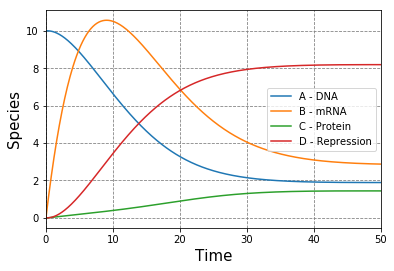

In [1]:
def dA(states,params,dt):
    return (-params[4]*states[0][-1]*states[2][-1]+params[5]*states[3][-1])*dt
def dB(states,params,dt):
    return (params[0]*states[0][-1]-params[2]*states[1][-1])*dt
def dC(states,params,dt):
    return (params[1]*states[1][-1]-params[3]*states[2][-1]-params[4]*states[0][-1]*states[2][-1]+params[5]*states[3][-1])*dt
def dD(states,params,dt):
    return (params[4]*states[0][-1]*states[2][-1]-params[5]*states[3][-1])*dt
    
params=[0.3,0.05,0.2,0.1,0.3,0.1] #[k1,k2,k3,k4,k5,k6]
states=[[10],[0],[0],[0]] #[A,B,C,D]
t=[0]
dt=0.1
maxt=50

while t[len(t)-1]<maxt:
    states[0].append(max(0,dA(states,params,dt)+states[0][-1]))
    states[1].append(max(0,dB(states,params,dt)+states[1][-1]))
    states[2].append(max(0,dC(states,params,dt)+states[2][-1]))
    states[3].append(max(0,dD(states,params,dt)+states[3][-1]))
    t.append(t[-1]+dt)
    
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(t,states[0],label='A - DNA')
plt.plot(t,states[1],label='B - mRNA')
plt.plot(t,states[2],label='C - Protein')
plt.plot(t,states[3],label='D - Repression')
plt.grid(b=True,which='major',color='grey',linestyle='--')
plt.xlabel('Time',size=15)
plt.ylabel('Species',size=15)
plt.legend()
plt.xlim(0,maxt)
plt.show()

## Stochastic model
Procedure for stochastic simulation algorithm:
0. Initialize time $t_o$ and system state $x$.
1. Evaluate propensities $a_j$ and $a_o(x)$.
2. Generate values for $\tau$ and $j$.
3. Effect the next reaction by $t \leftarrow t + \tau$ and $x \leftarrow x + v_j$.
4. Record $(x,t)$ and return to step 2.

\begin{equation}
j = \textrm{smallest integer satisfying} \sum_{j'=1}^{j} a_{j'}(x) > r_2a_o(x) \\
\tau = \frac{1}{a_o(x)}ln\biggl(\frac{1}{r_1}\biggr) \\
a_o(x)=\sum_{j'=1}^{M}a_{j'}(x)
\end{equation}

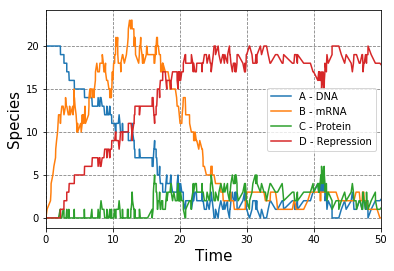

In [4]:
import numpy as np
def propensities(c,x):
    a=np.array([[c[0][-1]*x[0][-1]],
              [c[1][-1]*x[1][-1]],
              [c[2][-1]*x[1][-1]],
              [c[3][-1]*x[2][-1]],
              [c[4][-1]*x[0][-1]*x[2][-1]],
              [c[5][-1]*x[3][-1]]])
    sum_a=np.sum(a)
    return a,sum_a

def tau(sum_a):
    return np.log(1/np.random.uniform(0,1))/sum_a
    
def j(a,sum_a):
    r_2=np.random.uniform(0,1)
    j_temp=1
    while a[0:j_temp].sum()<r_2*np.sum(a):
        j_temp=j_temp+1
    return j_temp
        
def trajectory(c,x,v,t_max):
    t=[0]
    while t[-1]<t_max:
        a,sum_a=propensities(c,x)
        t.append(t[-1]+tau(sum_a))
        v_j=np.transpose([v[j(a,sum_a)-1][:]])
        x=np.append(x,np.transpose([x[:,-1]])+v_j,axis=1)
    return t,x

pre=np.array([[1,0,0,0],[0,1,0,0],[0,1,0,0],[0,0,1,0],[1,0,1,0],[0,0,0,1]])
post=np.array([[1,1,0,0],[0,1,1,0],[0,0,0,0],[0,0,0,0],[0,0,0,1],[1,0,1,0]])
v=post-pre #state change vector or net reaction

params=[0.3,0.05,0.2,0.1,0.3,0.1] #[k1,k2,k3,k4,k5,k6]
states=[20,0,0,0] #[A,B,C,D]
c=np.transpose([np.array(params)])
x=np.transpose([np.array(states)])
t_max=50
t,x=trajectory(c,x,v,t_max)

%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(t,x[0],label='A - DNA')
plt.plot(t,x[1],label='B - mRNA')
plt.plot(t,x[2],label='C - Protein')
plt.plot(t,x[3],label='D - Repression')
plt.grid(b=True,which='major',color='grey',linestyle='--')
plt.xlabel('Time',size=15)
plt.ylabel('Species',size=15)
plt.legend()
plt.xlim(0,t_max)
plt.show()

### Multiple trajectories to obtain distributions

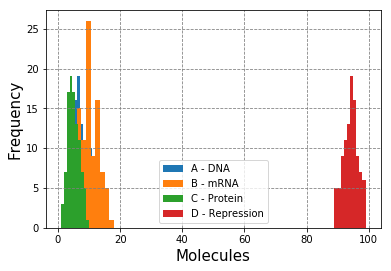

In [11]:
endpoints=np.array([[0,0,0,0]])
trajectories=100
for i in list(range(0,trajectories)):
    states=[100,0,0,0] #[A,B,C,D]
    x=np.transpose([np.array(states)])
    t,x=trajectory(c,x,v,t_max)
    endpoints=np.concatenate((endpoints,[x[:,-1]]),axis=0)
plt.hist(endpoints[1:,0],label='A - DNA')
plt.hist(endpoints[1:,1],label='B - mRNA')
plt.hist(endpoints[1:,2],label='C - Protein')
plt.hist(endpoints[1:,3],label='D - Repression')
plt.grid(b=True,which='major',color='grey',linestyle='--')
plt.xlabel('Molecules',size=15)
plt.ylabel('Frequency',size=15)
plt.legend()
plt.show()

## No mRNA model

This model accounts for proteins and regulatory mechanisms only (no mRNA intermediates).

\begin{equation}
Repressor + Operator \leftrightarrow Repressor:Operator \\
RNAP + Promoter \leftrightarrow RNAP:Promoter \\
RNAP:Promoter \rightarrow RNAP:Promoter + Repressor \\
Repressor \rightarrow 0 \\
\end{equation}

### Deterministic model
\begin{equation}
\frac{d(R)}{dt}=-k_1(R)(O)+k_{-1}(RO)+k_3(RNAPP)-k_4(R)\\
\frac{d(O)}{dt}=-k_1(R)(O)+k_{-1}(RO)\\
\frac{d(RO)}{dt}=k_1(R)(O)-k_{-1}(RO)\\
\frac{d(RNAP)}{dt}=-k_2(RNAP)(P)+k_{-2}(RNAPP)\\
\frac{d(RNAPP)}{dt}=k_2(RNAP)(P)-k_{-2}(RNAPP)\\
\frac{d(P)}{dt}=-k_2(RNAP)(P)+k_{-2}(RNAPP)\\
\end{equation}

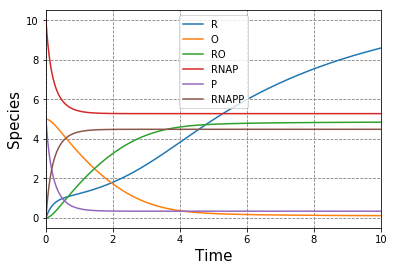

In [16]:
import math
def dR(states,params,dt):
    return (-params[0]*states[0][-1]*states[1][-1]+params[2]*states[3][-1]-params[5]*states[0][-1])*dt
def dO(states,params,dt):
    return (-params[0]*states[0][-1]*states[1][-1]+params[1]*states[2][-1])*dt
def dRO(states,params,dt):
    return (params[0]*states[0][-1]*states[1][-1]-params[1]*states[2][-1])*dt
def dRNAP(states,params,dt):
    return (-params[2]*states[3][-1]*states[4][-1]+params[3]*states[5][-1])*dt
def dP(states,params,dt):
    return (-params[2]*states[3][-1]*states[4][-1]+params[3]*states[5][-1])*dt
def dRNAPP(states,params,dt):
    return (params[2]*states[3][-1]*states[4][-1]-params[3]*states[5][-1])*dt

params=[0.5,0.1,0.5,0.2,0.3,0.2] #[k1,k-1,k2,k-2,k3,k4] or [kr,k-r,kp,k-p,ki,kdeg]
states=[[0],[5],[0],[10],[5],[0]] #[R,O,RO,RNAP,P,RNAPP]

t=[0]
dt=0.01
maxt=10

while t[len(t)-1]<maxt:
    states[0].append(max(0,dR(states,params,dt)+states[0][-1]))
    states[1].append(max(0,dO(states,params,dt)+states[1][-1]))
    states[2].append(max(0,dRO(states,params,dt)+states[2][-1]))
    states[3].append(max(0,dRNAP(states,params,dt)+states[3][-1]))
    states[4].append(max(0,dP(states,params,dt)+states[4][-1]))
    states[5].append(max(0,dRNAPP(states,params,dt)+states[5][-1]))
    t.append(t[-1]+dt)
    
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(t,states[0],label='R')
plt.plot(t,states[1],label='O')
plt.plot(t,states[2],label='RO')
plt.plot(t,states[3],label='RNAP')
plt.plot(t,states[4],label='P')
plt.plot(t,states[5],label='RNAPP')
plt.grid(b=True,which='major',color='grey',linestyle='--')
plt.xlabel('Time',size=15)
plt.ylabel('Species',size=15)
plt.legend()
plt.xlim(0,maxt)
plt.show()